# Reprodução de experimentos para 2 prossumidores
As equações de oferta e demanda utilizadas no artigo **A Prosumer-Based Energy Sharing Mechanism of Active Distribution Network Considering Household Energy Storage** são mostradas abaixo
$$
\begin{cases}
U^{\text{demand}}_i = a_i - b_i D_i \\
U^{\text{supply}}_i = \alpha_i + \beta_i S_i
\end{cases}
$$
onde $U^{\text{demand}}_i$ e $U^{\text{supply}}_i$ representam a curva de utilidade do consumo e suprimento de energia respectivamente, $a_i$, $b_i$, $\alpha_i$ e $\beta_i$ são parametros individuais do prossumidor. Como resultado é possível visualizar uma curva de oferta e demanda mostrada abaixo:

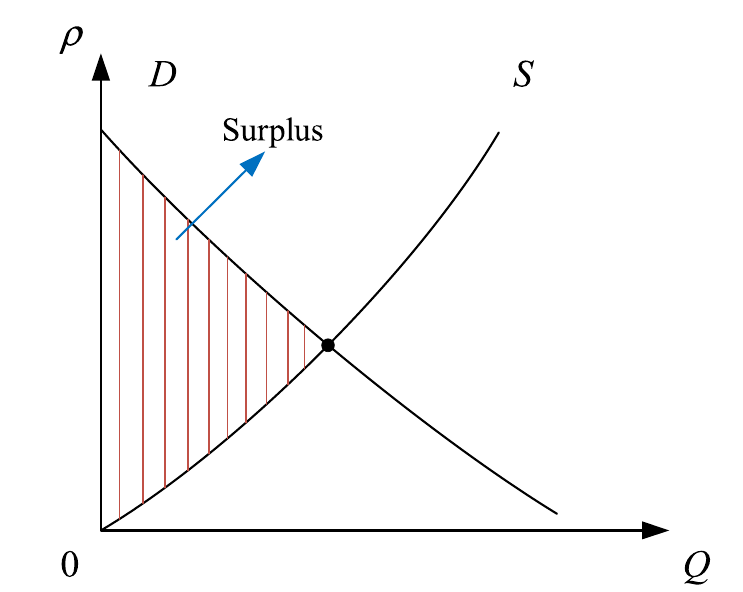

Já a utilidade para a carga e descarga da bateria segue a mesma lógica:
$$
\begin{cases}
U^{\text{charge}}_i = c^{\text{ch}}_i - d^{\text{ch}}_i Q^{\text{ch}}_i \\
U^{\text{discharge}}_i = c^{\text{dis}}_i + d^{\text{dis}}_i Q^{\text{dis}}_i
\end{cases}
$$
onde $U^{\text{charge}}_i$ e $U^{\text{discharge}}_i$ representam a curva de utilidade da carga e descarga de energia da bateria, $c^{\text{ch}}_i$, $d^{\text{ch}}_i$, $c^{\text{dis}}_i$ e $d^{\text{dis}}_i$ são parametro relacionados ao armazenamento de cada prossumidor.

A função objetivo mencionada no artigo, bem-estar social, é a área indicada na imagem acima, resultando na seguinte equação:
$$
\begin{aligned}
\max \sum_{i=1}^{N} \Big[ &a_i D_i - 0.5 b_i D_i^2 - \alpha_i S_i - 0.5 \beta_i S_i^2 + \\
&c^{\text{ch}}_i Q^{\text{ch}}_i - 0.5 d^{\text{ch}}_i (Q^{\text{ch}}_i)^2 - c^{\text{dis}}_i Q^{\text{dis}}_i - 0.5 d^{\text{dis}}_i (Q^{\text{dis}}_i)^2 - \\
&\gamma_i(Q^{\text{ch}}_i + Q^{\text{dis}}_i) \Big]
\end{aligned}
$$

In [1]:
using Pkg
Pkg.activate(".")
caminho_do_pacote = "/home/luizfreire/Documents/mestrado/powerModelsExemplos/PowerModelsDistributionDev"
Pkg.develop(PackageSpec(path=caminho_do_pacote))

  Activating project at `~/Documents/mestrado/powerModelsExemplos`
   Resolving package versions...
  No Changes to `~/Documents/mestrado/powerModelsExemplos/Project.toml`
  No Changes to `~/Documents/mestrado/powerModelsExemplos/Manifest.toml`


In [2]:
using PowerModelsDistribution
using Ipopt
using JuMP
using PowerPlots
using Plots

include("utils/load_data.jl")
results_path = "results/2025-04-21_solar_carga_armazenamento_opf_cost/"

solver = optimizer_with_attributes(
    Ipopt.Optimizer,
    "max_iter" => 10000,
    "tol" => 1e-8)


Precompiling PowerModelsDistribution
  ✓ PowerModelsDistribution
  1 dependency successfully precompiled in 10 seconds. 71 already precompiled.


MathOptInterface.OptimizerWithAttributes(Ipopt.Optimizer, Pair{MathOptInterface.AbstractOptimizerAttribute, Any}[MathOptInterface.RawOptimizerAttribute("max_iter") => 10000, MathOptInterface.RawOptimizerAttribute("tol") => 1.0e-8])

A tabela abaixo mostra os parametros de todos os parametros dos prossumidores
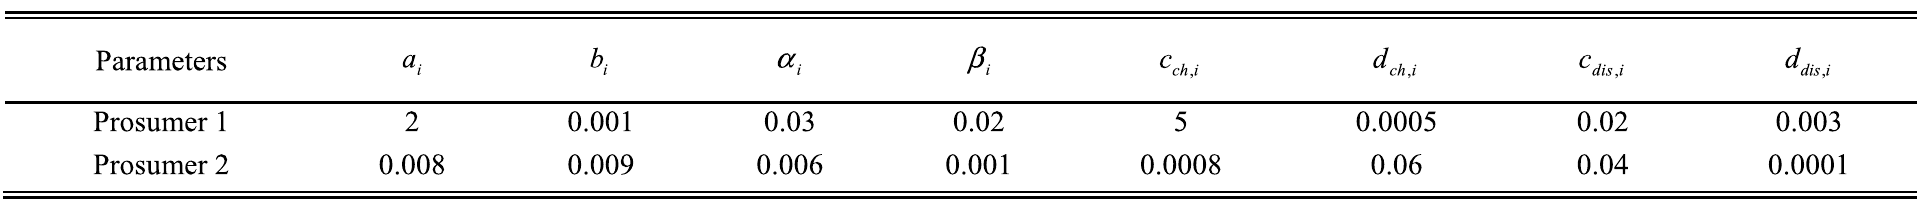

In [15]:
eng_model = PowerModelsDistribution.parse_file("PowerModelsDistributionDev/test/data/opendss/case_tabulation.dss")
delete!(eng_model["load"], "load_1")

# é necessário ajustar a base, pois os parametros do modelo estão em $/kwh
eng_model["settings"]["sbase_default"] = 1000
eng_model["settings"]["sbase"] = 1

# O modelo utilizado no artigo desconsidera as perdas
make_lossless!(eng_model)

add_prosumer!(eng_model,
              "prosumer_1",
              "bus_1",
              [1, 2, 3];
              configuration=WYE,
              pgp=7500,
              pgmax=150000,
              pdp=85000,
              pdmin=80000,
              pdmax=100000,
              psp=[1000, 1000, 1000],
              qgp=0,
              qdp=0,
              qsp=[0, 0, 0],
              energy=50000,
              energy_ub=100000,
              charge_ub=6000,
              discharge_ub=5000,
              charge_efficiency=100,
              discharge_efficiency=100,
              a=2.0,
              b=0.001,
              alpha=0.03,
              beta = 0.02,
              cch = 5.0,
              dch = 0.0005,
              cdis = 0.02,
              ddis = 0.003,
              p_shared = 1)


add_prosumer!(eng_model,
              "prosumer_2",
              "bus_1",
              [1, 2, 3];
              configuration=WYE,
              pgp=75000,
              pgmax=150000,
              pdp=150000,
              pdmin=140000,
              pdmax=200000,
              psp=[1000, 1000, 1000],
              qgp=0,
              qdp=0,
              qsp=[0, 0, 0],
              energy=50000,
              energy_ub=90000,
              charge_ub=6000,
              discharge_ub=5000,
              charge_efficiency=100,
              discharge_efficiency=100,
              a = 0.008,
              b = 0.009,
              alpha = 0.006,
              beta = 0.001,
              cch = 0.0008,
              dch = 0.06,
              cdis = 0.04,
              ddis = 0.0001,
              p_shared = 1)

[ PowerModelsDistribution | Info ] : Circuit has been reset with the 'clear' on line 1 in 'case_tabulation.dss'
[ PowerModelsDistribution | Info ] : Command 'solve' on line 5 in 'case_tabulation.dss' is not supported, skipping.
[ PowerModelsDistribution | Info ] : basemva=100 is the default value, you may want to adjust sbase_default for better convergence


Dict{String, Any} with 30 entries:
  "pdmin"             => 140000
  "cdis"              => 0.04
  "connections"       => [1, 2, 3]
  "pdmax"             => 200000
  "b"                 => 0.009
  "energy"            => 50000
  "p_shared"          => 1
  "bus"               => "bus_1"
  "a"                 => 0.008
  "charge_ub"         => 6000
  "configuration"     => WYE
  "energy_ub"         => 90000
  "qgp"               => 0
  "status"            => ENABLED
  "ddis"              => 0.0001
  "source_id"         => "prosumer.prosumer_2"
  "qsp"               => [0, 0, 0]
  "alpha"             => 0.006
  "charge_efficiency" => 100
  "discharge_ub"      => 5000
  "pgp"               => 75000
  "pgmax"             => 150000
  "beta"              => 0.001
  "dch"               => 0.06
  "pdp"               => 150000
  ⋮                   => ⋮

In [4]:
result = solve_mc_model(eng_model, ACPUPowerModel, solver, build_mc_tes_opf)

[ PowerModelsDistribution | Info ] : no active generators found at bus 1, updating to bus type from 2 to 1



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:       69
Number of nonzeros in inequality constraint Jacobian.:       27
Number of nonzeros in Lagrangian Hessian.............:       25

Total number of variables............................:       45
                     variables with only lower bounds:        3
                variables with lower and upper bounds:       10
                     variables with only upper bounds:        0
Total number of equality constraints.................:       30
Total number of inequality c

Dict{String, Any} with 8 entries:
  "solve_time"         => 0.0117259
  "optimizer"          => "Ipopt"
  "termination_status" => LOCALLY_SOLVED
  "dual_status"        => FEASIBLE_POINT
  "primal_status"      => FEASIBLE_POINT
  "objective"          => 40.0165
  "solution"           => Dict{String, Any}("voltage_source"=>Dict{String, Any}…
  "objective_lb"       => -Inf

In [16]:
# verificando se o compartilhamento de energia prevalece em relação a rede
result["solution"]["voltage_source"]["source"]

Dict{String, Any} with 4 entries:
  "qg_bus" => [0.0, 0.0, 0.0]
  "qg"     => [0.0, 0.0, 0.0]
  "pg"     => [6.01953e-9, 3.46193e-8, -4.06366e-8]
  "pg_bus" => [6.01953e-9, 3.46193e-8, -4.06366e-8]

In [17]:
d1 = result["solution"]["prosumer"]["prosumer_1"]["pdp"]
d2 = result["solution"]["prosumer"]["prosumer_2"]["pdp"]
s1 = result["solution"]["prosumer"]["prosumer_1"]["pgp"]
s2 = result["solution"]["prosumer"]["prosumer_2"]["pgp"]
e1 = result["solution"]["prosumer"]["prosumer_1"]["p_shared"]
e2 = result["solution"]["prosumer"]["prosumer_2"]["p_shared"]
social_welfare = result["objective"]

40.016457200532074

In [18]:
println("=== Resultados do Modelo de Compartilhamento de Energia ===")
println("→ Demanda de Energia (D_i):")
println("  Prosumer 1: ", d1, " kWh")
println("  Prosumer 2: ", d2, " kWh\n")

println("→ Geração de Energia (S_i):")
println("  Prosumer 1: ", s1, " kWh")
println("  Prosumer 2: ", s2, " kWh\n")

println("→ Energia Compartilhada (E_i):")
println("  Prosumer 1: ", e1, " kWh")
println("  Prosumer 2: ", e2, " kWh\n")

println("→ Bem-Estar Social (Social Welfare):")
println("  Total: ", social_welfare, " \$")

=== Resultados do Modelo de Compartilhamento de Energia ===
→ Demanda de Energia (D_i):
  Prosumer 1: 100.00000094987465 kWh
  Prosumer 2: 139.99999860080783 kWh

→ Geração de Energia (S_i):
  Prosumer 1: 90.99999806275049 kWh
  Prosumer 2: 150.0000014985207 kWh

→ Energia Compartilhada (E_i):
  Prosumer 1: 15.000002946327792 kWh
  Prosumer 2: -15.000002946327792 kWh

→ Bem-Estar Social (Social Welfare):
  Total: 40.016457200532074 $


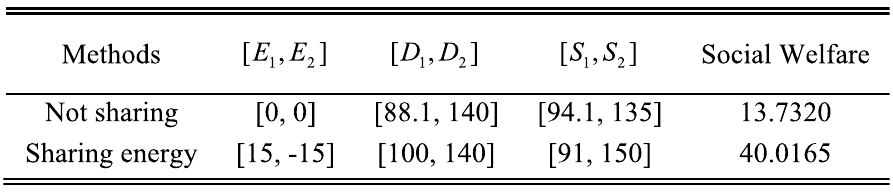